# The Merit Order Effect in Germany

In [15]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code On/Off"></form>''')

In [1]:
# import packages

import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

plt.style.use('Solarize_Light2')
%matplotlib inline

In [148]:
# set plot preferences

# plt.rcParams['figure.figsize'] = (18, 12)
# plt.rcParams['figure.dpi'] = 300

In [111]:
# import wind data

folder_path_w = r'C:\Users\dt0955\OneDrive\Jupyter\Merit Order Effect\data\fraunhofer\scatter\wind'
os.chdir(folder_path_w)

wind = pd.DataFrame(columns=['date', 'wind', 'price'])

for data_file in sorted(os.listdir(folder_path_w)):
    with open(data_file) as f:
        wind_temp = pd.DataFrame(json.load(f), columns=['date', 'wind', 'price'])
        wind = wind.append(wind_temp, ignore_index=True)
        
wind['date'] = pd.to_datetime(wind['date'], unit='ms')
wind = wind.set_index('date')

# import solar data

folder_path_s = r'C:\Users\dt0955\OneDrive\Jupyter\Merit Order Effect\data\fraunhofer\scatter\solar'
os.chdir(folder_path_s)

solar = pd.DataFrame(columns=['date', 'solar', 'price'])

for data_file in sorted(os.listdir(folder_path_s)):
    with open(data_file) as f:
        solar_temp = pd.DataFrame(json.load(f), columns=['date', 'solar', 'price'])
        solar = solar.append(solar_temp, ignore_index=True)
        
solar['date'] = pd.to_datetime(solar['date'], unit='ms')
solar = solar.set_index('date')

# import load data

folder_path_l = r'C:\Users\dt0955\OneDrive\Jupyter\Merit Order Effect\data\fraunhofer\scatter\load'
os.chdir(folder_path_l)

load = pd.DataFrame(columns=['date', 'load', 'price'])

for data_file in sorted(os.listdir(folder_path_l)):
    with open(data_file) as f:
        load_temp = pd.DataFrame(json.load(f), columns=['date', 'load', 'price'])
        load = load.append(load_temp, ignore_index=True)
        
load['date'] = pd.to_datetime(load['date'], unit='ms')
load = load.set_index('date')

# gather all dat into single array

data_all = wind.assign(solar=solar['solar'].values, load=load['load'].values)
data_all = data_all[['wind', 'solar', 'load', 'price']]
data_all = data_all.dropna() # drop missing values
data_all = data_all[data_all.load!=0] # drop missing load values

Data was download from Fraunhofer's [Energy Charts](https://energy-charts.de/) website. A sample of the data is shown below: our focus is naturally on wind and solar; the total load is a good proxy for demand. The units for electricity are MWh and the price is in EUR/MWh

In [9]:
data_all.head()

,wind,solar,load,price
date,,,,
2009-12-31 23:00:00,3.665,0.0,45.423,26.25
2010-01-01 00:00:00,3.630,0.0,44.958,18.46
2010-01-01 01:00:00,3.570,0.0,43.357,20.08
2010-01-01 02:00:00,3.473,0.0,41.577,16.99
2010-01-01 03:00:00,3.201,0.0,40.239,15.92


***
## Total Average Merit Order Effect

As a first attempt, we follow [Cludius et. al](https://doi.org/10.1016/j.eneco.2014.04.020), and model the spot price as dependent on the feed-in of _wind_ and _solar_, with _load_ as an indicator for total demand. We also introduce hourly, daily, monthly and yearly dummies to control for systematic changes in demand. Seven dummies for the days of the week are also introduced.
$$
    \mathrm{Spot}_t = \beta_1 \mathrm{wind}_t + \beta_2 \mathrm{solar}_t + \beta_3 \mathrm{load}_t + \mathrm{dummies}\ .
$$

We obtain the following coeffecients.

In [135]:
years = np.arange(2010, 2019, 1)

coeff_table = []

for year in years:
    
    x_data = data_all[['wind', 'solar', 'load']].loc[data_all.index.year==year].values
    
    dummy_number = 24 + 7 + 12 + 4 # hours + days + months + months + seasons
    reg_x = np.ones((x_data.shape[0], x_data.shape[1] + dummy_number))

    reg_x[:, :-dummy_number] = x_data # x-data for regression
    
    reg_y = data_all[['price']].loc[data_all.index.year==year].values.transpose() # y-data for regession
    reg_y = reg_y.flatten()
    
    model = LinearRegression().fit(reg_x, reg_y)
    
    coeff_table.append([np.int(year), *model.coef_[0:3], model.score(reg_x, reg_y)])
    
coeff_table = np.array(coeff_table)

In [137]:
display(HTML(tabulate(coeff_table, headers=["Year", "Wind Coef. (EUR/MWh^2)", "Solar Coef. (EUR/MWh^2)", "Load Coef. (EUR/MWh^2)", "R^2"],
               floatfmt=(".0f", ".3f", ".3f", ".3f", ".3f"), tablefmt='html')))

Year,Wind Coef. (EUR/MWh^2),Solar Coef. (EUR/MWh^2),Load Coef. (EUR/MWh^2),R^2
2010,-1.135,0.298,1.207,0.684
2011,-1.201,-0.305,1.068,0.691
2012,-1.255,-1.030,1.388,0.632
2013,-1.309,-1.072,1.441,0.777
2014,-1.027,-0.949,1.129,0.817
2015,-0.999,-0.737,0.972,0.788
2016,-0.934,-0.832,0.932,0.664
2017,-1.286,-1.152,1.286,0.735
2018,-1.295,-0.930,1.130,0.584


To compute the total average MO effect, we need to multiply these specific effects with the load-weighted everage wind or PV feed-in per hour in the respective year:

In [19]:
mo_table = []

for year in years:
    
    data_year = data_all.loc[data_all.index.year==year]
    
    wind_weigh = np.sum(data_year['load'].values * data_year['wind'].values) / np.sum(data_year['load'].values)
    solar_weigh = np.sum(data_year['load'].values * data_year['solar'].values) / np.sum(data_year['load'].values)
    
    # convert coeff. table to pandas Dataframe
    coeff_pd = pd.DataFrame(coeff_table).set_index([0])
    coeffs = coeff_pd.loc[coeff_pd.index==year]
    
    wind_coeff = coeffs[1].values[0]
    solar_coeff = coeffs[2].values[0]
    
    mo_wind = wind_coeff*wind_weigh
    mo_solar = solar_coeff*solar_weigh
    mo = mo_wind + mo_solar
    
    mo_table.append([np.int(year), mo_wind, mo_solar, mo])
    
mo_table = np.array(mo_table)
display(HTML(tabulate(mo_table, headers=["Year", "MOE Wind (EUR/MWh)", "MOE Solar (EUR/MWh)", "MOE Total (EUR/MWh)"], floatfmt=(".0f", ".2f", ".2f", ".2f"), tablefmt='html')))

Year,MOE Wind (EUR/MWh),MOE Solar (EUR/MWh),MOE Total (EUR/MWh)
2010,-5.01,0.42,-4.59
2011,-6.81,-0.74,-7.55
2012,-7.19,-3.41,-10.61
2013,-7.74,-4.16,-11.89
2014,-6.75,-4.31,-11.06
2015,-9.08,-3.54,-12.62
2016,-8.31,-3.94,-12.25
2017,-15.48,-5.50,-20.98
2018,-16.55,-4.99,-21.54


Apart from a slight abberration in 2010 with the solar MOE, the results are as expected: the MOE increases with each passing year.
***
## The MOE as a function of Demand

We begin by examining a historgram of the load (demand), lumped into 5 MWh bins.

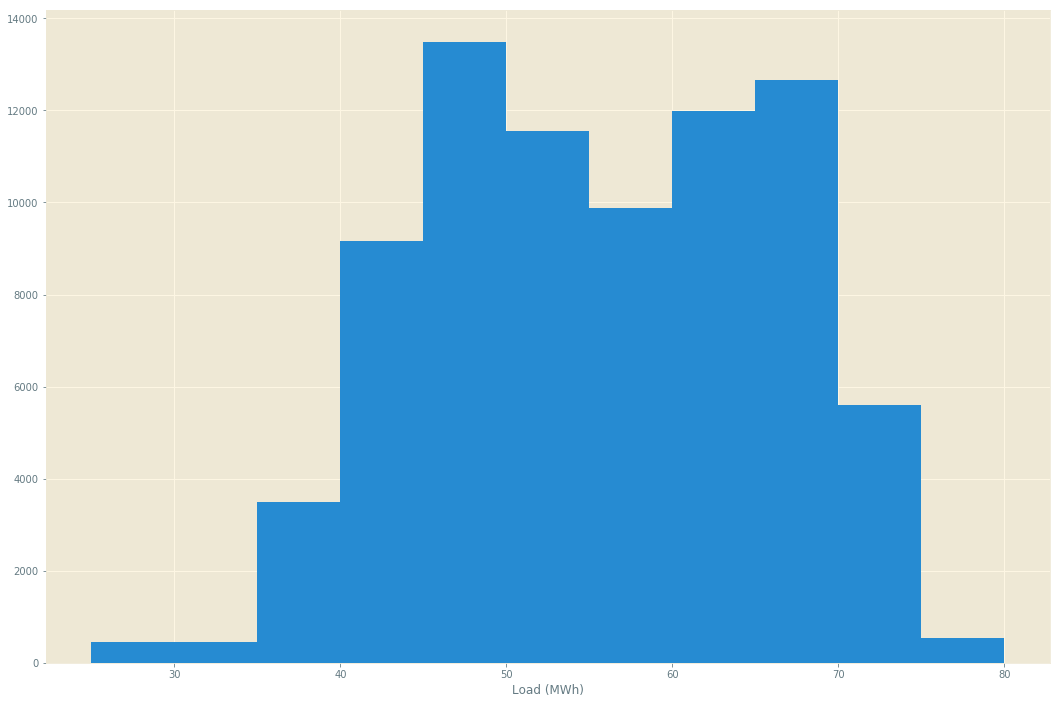

In [150]:
bin_array = [25, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

ax = data_all[data_all.load!=0].load.hist(bins=bin_array)
ax.set_xlabel('Load (MWh)');

The demand clumps strongly around the average.

As above, we perform a linear regression, obtaining the following coefficients and the total average MOE.

In [151]:
data_all['binned'] = pd.cut(data_all[data_all.load!=0].load, bin_array)
bins = pd.IntervalIndex.from_breaks(bin_array)

coeff_table_2 = []

for bin in bins:
    
    x_data = data_all[['wind', 'solar', 'load']].loc[data_all.binned==bin].values
    
    dummy_number = 24 + 7 + 12 + 4 # hours + days + months + months + seasons
    reg_x = np.ones((x_data.shape[0], x_data.shape[1] + dummy_number))

    reg_x[:, :-dummy_number] = x_data # x-data for regression
    
    reg_y = data_all[data_all.binned==bin].price.values.transpose() # y-data for regession
    reg_y = reg_y.flatten()
    
    model = LinearRegression().fit(reg_x, reg_y)
    
    coeff_table_2.append([bin, *model.coef_[0:3], model.score(reg_x, reg_y)])
    
coeff_table_2 = np.array(coeff_table_2)

In [153]:
display(HTML(tabulate(coeff_table_2, headers=["Bin (MWh)", "Wind Coef. (EUR/MWh^2)", "Solar Coef. (EUR/MWh^2)", "Load Coef. (EUR/MWh^2)", "R^2"],
               floatfmt=(".0f", ".3f", ".3f", ".3f", ".3f"), tablefmt='html')))

Bin (MWh),Wind Coef. (EUR/MWh^2),Solar Coef. (EUR/MWh^2),Load Coef. (EUR/MWh^2),R^2
"(25, 35]",-2.463,0.787,11.409,0.359
"(35, 40]",-1.392,-1.077,1.562,0.395
"(40, 45]",-1.353,-1.004,1.260,0.442
"(45, 50]",-1.176,-0.903,1.069,0.424
"(50, 55]",-1.075,-0.801,1.141,0.435
"(55, 60]",-1.007,-0.727,1.080,0.416
"(60, 65]",-1.094,-0.961,1.344,0.418
"(65, 70]",-1.096,-0.984,1.096,0.441
"(70, 75]",-1.157,-1.324,0.882,0.476
"(75, 80]",-0.820,-1.441,1.378,0.534


__N.B.__ The $R^2$ values here are not the best. Further fit analysis is required.

In [154]:
mo_table_2 = []

for bin in bins:
    
    data_bin = data_all.loc[data_all.binned==bin]
    
    wind_weigh = np.sum(data_bin['load'].values * data_bin['wind'].values) / np.sum(data_bin['load'].values)
    solar_weigh = np.sum(data_bin['load'].values * data_bin['solar'].values) / np.sum(data_bin['load'].values)
    
    # convert coeff. table to pandas Dataframe
    coeff_pd = pd.DataFrame(coeff_table_2).set_index([0])
    coeffs = coeff_pd.loc[coeff_pd.index==bin]
    
    wind_coeff = coeffs[1].values[0]
    solar_coeff = coeffs[2].values[0]
    
    mo_wind = wind_coeff*wind_weigh
    mo_solar = solar_coeff*solar_weigh
    mo = mo_wind + mo_solar
    
    mo_table_2.append([bin, mo_wind, mo_solar, mo])
    
mo_table_2 = np.array(mo_table_2)

In [155]:
display(HTML(tabulate(mo_table_2, headers=["Bins [MWh]", "MOE Wind (EUR/MWh)", "MOE Solar (EUR/MWh)", "MOE Total (EUR/MWh)"], floatfmt=(".0f", ".2f", ".2f", ".2f"), tablefmt='html')))

Bins [MWh],MOE Wind (EUR/MWh),MOE Solar (EUR/MWh),MOE Total (EUR/MWh)
"(25, 35]",-17.52,0.14,-17.38
"(35, 40]",-8.96,-0.33,-9.29
"(40, 45]",-9.28,-0.98,-10.27
"(45, 50]",-8.74,-2.03,-10.77
"(50, 55]",-9.08,-2.26,-11.34
"(55, 60]",-7.96,-2.02,-9.97
"(60, 65]",-7.69,-5.02,-12.71
"(65, 70]",-8.41,-7.05,-15.46
"(70, 75]",-12.66,-6.72,-19.38
"(75, 80]",-14.59,-2.95,-17.54


These results are a little harder to interpret. Ignoring the first bin, it seems as though the MOE increases with demand (_is this expected?_). There are however, not enough points for a clear matter to emerge.